In [1]:
import numpy as np
import pandas as pd
from scipy.signal import welch  # for series frequency visualization 
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score
import zipfile
import requests
from io import BytesIO
import os
import torch
from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

# Data (down)loading and exploration

In [2]:
def download_read_dataset(dataset):
    """
    Downloads dataset zip file, exctracts, and creates train and test Dataframes.
    
    The datasets are from www.timeseriesclassification.com.
    """
    
    zip_url = f'http://www.timeseriesclassification.com/Downloads/{dataset}.zip'
    zip_file = zipfile.ZipFile(BytesIO(requests.get(zip_url).content))
    train_bytes_file = BytesIO(zip_file.read(f'{dataset}_TRAIN.txt'))
    test_bytes_file = BytesIO(zip_file.read(f'{dataset}_TEST.txt'))
    
    return [pd.read_csv(bytes_file, header=None, delimiter='\s+') for bytes_file in [train_bytes_file, test_bytes_file]]

In [3]:
def fix_class_column(df):
    df.rename({0: 'Class'}, axis=1, inplace=True)
    df['Class'] = df['Class'].astype('int32')

In [4]:
# Choose dataset name from http://www.timeseriesclassification.com/
dataset = 'Worms'  # ['CBF', 'TwoPatterns', 'Worms', 'WormsTwoClass']

In [5]:
# Download and read dataset
train_df, test_df = download_read_dataset(dataset)

In [6]:
# Fix class column
fix_class_column(train_df)
fix_class_column(test_df)

In [7]:
#dir_path = os.path.join('E:\Datasets\TimeSeriesAnalysis\Classification', f'{dataset}')
#train_file_path = os.path.join(dir_path, f'{dataset}_TRAIN.txt')
#test_file_path = os.path.join(dir_path, f'{dataset}_TEST.txt')
#train_df = pd.read_csv(train_file_path, header=None, delimiter='\s+')
#test_df = pd.read_csv(test_file_path, header=None, delimiter='\s+')

In [8]:
train_df.head()

,Class,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
0,1,1.660505,1.739092,1.812766,1.847148,1.901176,1.935558,1.906088,1.945381,1.925735,...,-0.363097,-0.422037,-0.397478,-0.402390,-0.402390,-0.402390,-0.441683,-0.431860,-0.495712,-0.505535
1,1,-0.379133,0.242145,-0.517195,-0.033979,0.587299,-0.517195,-0.172040,0.035052,0.518269,...,-3.485523,-3.623585,-2.311998,-3.278430,-2.864245,-3.278430,-3.002307,-2.864245,-2.726183,-3.071337
2,1,0.534425,0.444349,0.399312,0.511906,0.669539,0.714577,0.511906,0.692058,0.489387,...,3.799677,3.934791,3.754639,4.024867,3.799677,3.777158,3.777158,3.574488,3.844715,3.574488
3,1,-2.438882,-2.412564,-2.438882,-2.333611,-2.267818,-2.307294,-2.412564,-2.162547,-2.241500,...,-1.715148,-1.767783,-1.794101,-1.688830,-1.701989,-1.701989,-1.767783,-1.767783,-1.754624,-1.767783
4,1,1.601259,1.601259,1.589440,1.589440,1.589440,1.589440,1.589440,1.577622,1.577622,...,3.445002,3.208625,3.244082,3.125893,3.031342,2.948610,2.854059,2.783146,2.794965,2.854059


In [9]:
train_df.shape

(181, 901)

In [10]:
test_df.head()

,Class,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
0,1,-0.778589,-0.744436,-0.725462,-0.702693,-0.714077,-0.721667,-0.733052,-0.717872,-0.736846,...,0.082832,0.052474,-0.042396,-0.099319,-0.125882,-0.190394,-0.228342,-0.205573,-0.273880,-0.323212
1,1,0.017272,-0.071910,-0.083542,-0.091297,-0.106807,-0.149459,-0.215376,-0.211499,-0.199866,...,0.668686,0.684196,0.672564,0.722971,0.742358,0.753991,0.781133,0.788888,0.796643,0.804398
2,1,0.083460,0.074729,0.079095,0.083460,0.135847,0.179503,0.236255,0.319201,0.419610,...,0.476362,0.454534,0.458900,0.471997,0.489459,0.476362,0.489459,0.493824,0.489459,0.476362
3,1,-1.298560,-1.171976,-1.087587,-0.991141,-0.997169,-1.015253,-1.009225,-0.979086,-0.991141,...,-0.563166,-0.502888,-0.502888,-0.412471,-0.370276,-0.297942,-0.231636,-0.183413,-0.123135,-0.099024
4,1,-0.576294,-0.594890,-0.617206,-0.654399,-0.672995,-0.680433,-0.717626,-0.747380,-0.751099,...,-1.379653,-1.372214,-1.372214,-1.320145,-1.312706,-1.286672,-1.268075,-1.238321,-1.193690,-1.145340


In [11]:
test_df.shape

(77, 901)

#### Mean values histogram (to determine whether standartization is needed)

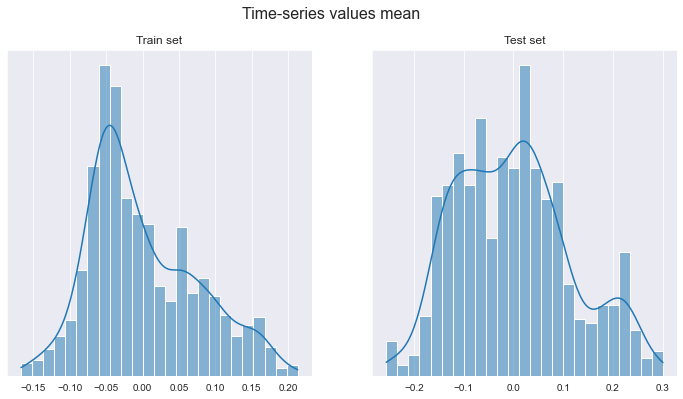

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plt.rcParams["axes.grid"] = True
sns.histplot(train_df.iloc[:, 1:].mean(), kde=True, bins=25, ax=ax[0])
sns.histplot(test_df.iloc[:, 1:].mean(), kde=True, bins=25, ax=ax[1])
fig.suptitle('Time-series values mean', fontsize=16)
ax[0].set_title('Train set'); ax[1].set_title('Test set')
ax[0].set_ylabel(None); ax[1].set_ylabel(None)
ax[0].set_yticks([]); ax[1].set_yticks([])
plt.show()

#### Visualize data samples

In [13]:
samples_per_class = 5

In [14]:
num_classes = train_df['Class'].nunique()

# Sample samples_per_class samples of each class
samples_df = pd.concat([train_df[train_df['Class']==c+1].sample(samples_per_class, replace=False) for c in range(num_classes)])

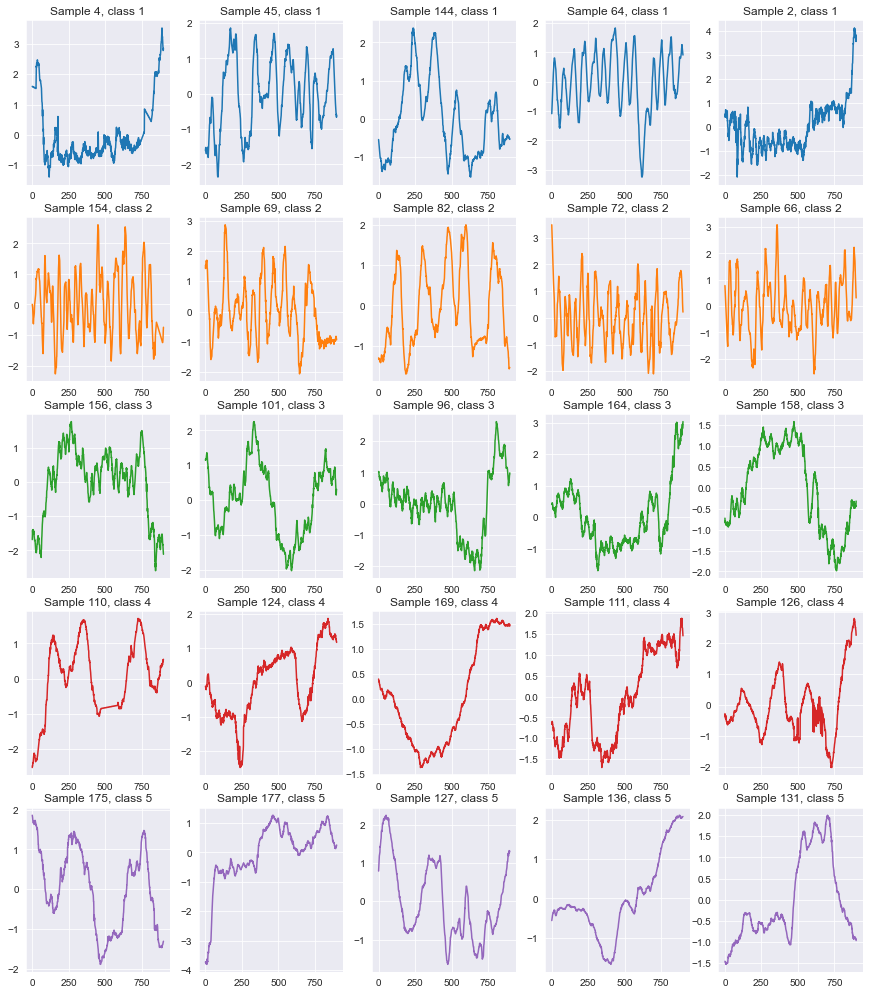

In [15]:
plt.figure(figsize=(samples_per_class * 3, num_classes * 3.5))
plt.rcParams["axes.grid"] = True
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'] * 10
for i, (sample_idx, sample_class, *sample_time_series) in enumerate(samples_df.itertuples()):
    ax = plt.subplot(num_classes, samples_per_class, i + 1)
    ax.plot(range(len(sample_time_series)), sample_time_series, c=colors[sample_class-1])
    ax.xticks=False
    plt.title(f"Sample {sample_idx}, class {sample_class}", fontsize=12)

#### Visualize data samples in frequency domain

In [16]:
nperseg = min(train_df.shape[1] - 1, 256)
f, w = welch(samples_df.iloc[:, 1:].values, nperseg=nperseg, fs=1)

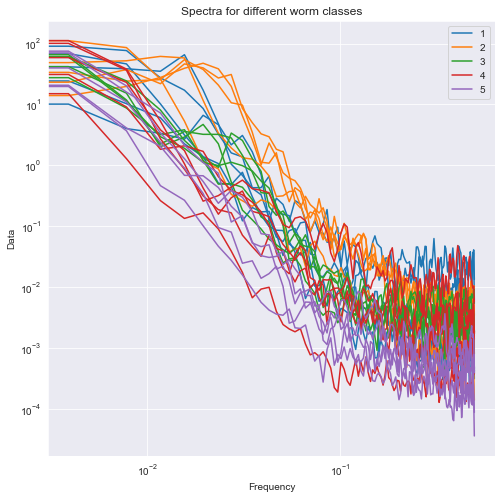

In [17]:
plt.figure(figsize=(8, 8))
plt.rcParams["axes.grid"] = True
for i, (sample_idx, sample_class, *sample_time_series) in enumerate(samples_df.itertuples()):    
    plt.plot(f, w[i], c=colors[sample_class-1], label=sample_class if i%num_classes==0 else '')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Data")
plt.title("Spectra for different worm classes", fontsize=12)
plt.show()

# ROCKET Model

In [18]:
class RocketTransformer():
    """A class to transform the data, i.e create features for a linear classifer."""
    
    def __init__(self, series_length, k):
        self._series_length = series_length
        self._kernels = [self._create_random_kernel() for i in range(k)]
        
    def transform(self, df):
        """
        Transform a pandas.DataFrame to features for a linear classifier.
        
        Note that the DataFrame's format should comply with http://www.timeseriesclassification.com/ datasets.
        
        Returns:
            A tuple composed of two numpy arrays - features and classes.
        """
        
        classes = df.iloc[:, :1].values.squeeze()
        
        # Convert to tensor 
        samples = torch.Tensor(df.iloc[:, 1:].values)
        
        all_samples_features = []
        for sample in tqdm(samples):
            
            # Reshape to conform to pytorch convolution kernels
            sample = sample.reshape(1, 1, -1)
            
            features = []
            for kernel in self._kernels:
                
                # Convolve
                feature_map = kernel(sample)
                
                # Global max
                features.append(feature_map.max().item())
                
                # PPV
                features.append(((feature_map>0).sum() / feature_map.shape[-1]).item())
            
            # Concatenate all features to an array
            all_samples_features.append(np.array(features))
            
        # Stack all feature arrays
        all_samples_features = np.stack(all_samples_features)
            
        return all_samples_features, classes
    
    def _create_random_kernel(self):
        """Creates a random convolution kernel."""
    
        # Length
        kernel_length = np.random.choice([7, 9, 11])

        # Dilation
        dilation_exp_dist = np.random.uniform(0, np.log2((self._series_length - 1) / (kernel_length - 1)))
        dilation = int(np.power(2, dilation_exp_dist))

        # Padding
        padding_bool = np.random.choice([True, False])
        padding = int(((kernel_length - 1) * dilation) / 2) if padding_bool else 0

        # Weights (tesnor)
        weights = torch.normal(0, 1, size =(1, 1, kernel_length))
        weights -= weights.mean()

        # Bias (tesnor)
        bias = torch.zeros(1).uniform_(-1, 1)

        # Create the kernel
        kernel = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_length, padding=padding, dilation=dilation)

        # Update weights and bias, and cancel gradient requirement
        kernel.weight = nn.Parameter(weights); kernel.weight.requires_grad=False
        kernel.bias = nn.Parameter(bias); kernel.bias.requires_grad=False

        return kernel

In [19]:
class Rocket():
    """
    A class that implments ROCKET model.
    
    The structure is sklearn models alike, and the methods operate on pandas.DataFrame objects.
    """
    
    def __init__(self, series_length, linear_clf, k=100):
        """
        series_length: Data series length (requires same length for all data samples).
        linear_clf: An initialized sklearn linear model object, e.g, "sklearn.linear_model.RidgeClassifier()"
        k: Number of random convolution kernel to create. Paper suggests 10,000 as default.
        """
        self._transformer = RocketTransformer(series_length=series_length, k=k)
        self._clf = linear_clf
        
    def fit(self, df: pd.DataFrame):
        X_train, y_train = self._transformer.transform(df)
        self._clf.fit(X_train, y_train)
        
    def predict(self, df: pd.DataFrame):
        X_test, y_test = self._transformer.transform(df)
        return self._clf.predict(X_test)
        
    def confusion_matrix(self, df: pd.DataFrame):
        """Plots a confusion matrix and computes metrics."""
        
        # Transform
        X_test, y_test = self._transformer.transform(df)
        
        # Predict
        predictions = self._clf.predict(X_test)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, predictions, labels=self._clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self._clf.classes_)
        plt.rcParams["axes.grid"] = False
        
        # Compute metrics
        acc = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='macro')
        prc = precision_score(y_test, predictions, average='macro')
        rec = recall_score(y_test, predictions, average='macro')
        
        print(f'Accuracy:  {acc:.3f}\nF1:        {f1:.3f}\nPrecision: {prc:.3f}\nRecall:    {rec:.3f}\n')
        print('Confusion Matrix:')
        disp.plot(cmap='Blues')

In [25]:
# Choose Logistic Regression (LogisticRegression()) or Ridge Regression Classifier (RidgeClassifier())
clf = RidgeClassifier(normalize=True)
#clf = LogisticRegression(max_iter=5000)

In [26]:
series_length = train_df.shape[1] - 1
print(f'Series length: {series_length}')

Series length: 900


In [27]:
rocket = Rocket(series_length, clf, k=10000)

In [28]:
rocket.fit(train_df)

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Accuracy:  0.727
F1:        0.691
Precision: 0.688
Recall:    0.700

Confusion Matrix:


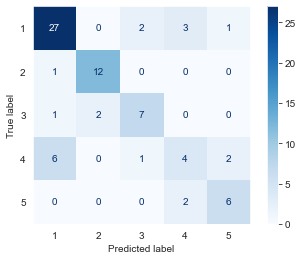

In [29]:
rocket.confusion_matrix(test_df)

In [ ]:
#rocket.predict(test_df)